In [6]:
# importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# loading and preprocessing the IMDB dataset
vocab_size = 10000
maxlen = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train_padded = pad_sequences(x_train, maxlen=maxlen)
x_test_padded = pad_sequences(x_test, maxlen=maxlen)

print(f"Training data shape: {x_train_padded.shape}")
print(f"Testing data shape: {x_test_padded.shape}")

# # saving the padded data for future use
# np.save("x_train_padded.npy", x_train_padded)
# np.save("y_train.npy", y_train)
# np.save("x_test_padded.npy", x_test_padded)
# np.save("y_test.npy", y_test)

Training data shape: (25000, 200)
Testing data shape: (25000, 200)


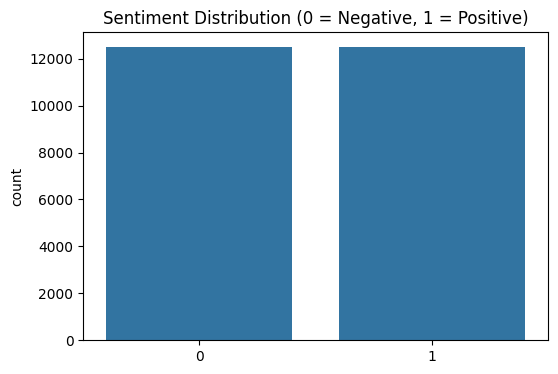

In [3]:
# Count positive vs negative reviews
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Sentiment Distribution (0 = Negative, 1 = Positive)")
plt.show()

In [4]:
# building the model
model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# compiling the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()


# callbacks
callbacks = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# training the model
history = model.fit(x_train_padded, y_train, epochs=5, batch_size=132, validation_data= (x_test_padded, y_test), callbacks=[callbacks])

d:\Sentiment Analysis Web App\web_app_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 32)        │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,303,025 (4.97 MB)

 Trainable params: 1,303,025 (4.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 110s 524ms/step - accuracy: 0.7988 - loss: 0.4273 - val_accuracy: 0.8703 - val_loss: 0.3154
Epoch 2/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 75s 397ms/step - accuracy: 0.9044 - loss: 0.2504 - val_accuracy: 0.8709 - val_loss: 0.3088
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 76s 398ms/step - accuracy: 0.9355 - loss: 0.1796 - val_accuracy: 0.8629 - val_loss: 0.3566
Epoch 4/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 80s 423ms/step - accuracy: 0.9544 - loss: 0.1329 - val_accuracy: 0.8627 - val_loss: 0.3692
Epoch 5/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 75s 396ms/step - accuracy: 0.9666 - loss: 0.1004 - val_accuracy: 0.8545 - val_loss: 0.4279


In [5]:
# evaluating the model
loss, accuracy = model.evaluate(x_test_padded, y_test)
print(f"model Accuracy: {accuracy*100:.2f}% ")

782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.8709 - loss: 0.3088
model Accuracy: 87.09% 


In [10]:
# save the model
model.save("sentiment_analysis_model.h5")

In [12]:
# save the tokenizer
word_index = imdb.get_word_index()
# shift indices by 3 to account for Keras reserved indices (0: padding, 1:start, 2:OOV)
word_index = {word: (idx + 3) for word, idx in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

# create a Tokenizer-like object and attach mappings so you can use it later
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.word_index = word_index
tokenizer.index_word = {idx: word for word, idx in word_index.items()}

with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of bfafd718b763782e994055a2d397834f so we will re-download the data.
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 4s 2us/step
